# Data analysis with XGBoost (Company motorbikes registrations in Bohemia example)

This notebook demontrates how to:
1. load data from Extera Feature Store
2. feature engineering for xgboost model
3. find optimal hyperparameters for model using cross validation
4. train model
5. explain model feature importance with eli5 and shap

Corresponding article: [https://www.mindforce.ai/post/jak%C3%A9-firmy-si-v-%C4%8Dr-kupuj%C3%AD-motorky-a-jak-je-naj%C3%ADt-s-pomoci-ai](https://www.mindforce.ai/post/jak%C3%A9-firmy-si-v-%C4%8Dr-kupuj%C3%AD-motorky-a-jak-je-naj%C3%ADt-s-pomoci-ai)

## Set Up

1. Install pandas, sklearn and xgboost

In [1]:
# data load & preparation
import pandas as pd
from sklearn.model_selection import train_test_split
# data model
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report 
# model explain
import shap
# from pandas_profiling import ProfileReport

In [10]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## Load data from Extera Feature Store


In [3]:
moto_data_query = '''
--26k records for 11k entrepreneurs, 16k companies 
with vozidla_L as
  (
  SELECT 
  fsob.* except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky, vhcl_flag),
  if(vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky>0,1,0) as moto_class_target
  FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
  inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
  where fsob.sid in
    (
    select distinct owner_sid from `steady-vine-203410.nexus.vehicle_registration` vr 
    where vr.vehicle_category_code in ('L') --  motorbikes
    )
  and org.abolishment_date = '9999-12-31' -- companies/entrepreneurs still alive
  )
/*11 *5 = 55k sample entrepreneurs*/
, non_L_sample_ent as
  (
  select
  fsob.* except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky, vhcl_flag),
  0 as moto_class_target
  FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
  inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
  where fsob.sid not in (select sid from vozidla_L) 
  -- minimum record quality requirements
  and org.region is not null 
  and org.nace_level_2 is not null
  and org.abolishment_date = '9999-12-31'
  and org.interruption_date is null
  and org.ent_flag = 'Y'
  order by sid desc # = by hash = random
  limit 55000
)
, non_L_sample_comp as
  (
  select
  fsob.* except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky,  vhcl_flag),
  0 as moto_class_target
  FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
  inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
  where fsob.sid not in (select sid from vozidla_L) 
  -- minimum record quality requirements
  and org.region is not null 
  and org.nace_level_2 is not null
  and org.abolishment_date = '9999-12-31'
  and org.turnover_category_code is not null
  and org.ent_flag = 'N'
  order by sid desc # = by hash = random
  limit 80000
)
select * except (sid) from vozidla_L
union all
select * except (sid) from non_L_sample_ent
union all
select * except (sid) from non_L_sample_comp
'''

moto_model_data = pd.read_gbq(project_id='steady-vine-203410',query = moto_data_query)

## Data preparation & feature engineering for xgboost model


In [11]:
moto_model_data.describe()

,VAT_payer,VAT_unreliable_flag,turnover_category_code,emp_category_code,ent_flag,branch_cnt,eshop_flg,profit,profit_change,assets,assets_change,net_turnover,net_turnover_change,patent_cnt,industrial_pattern_cnt,trademark_cnt,contractee_tender_value_total,contract_award_value_total,eu_subsidy_2020_amount,cz_subsidy_amount,szif_subsidy_amount,bo_avg_age,sta_avg_age,org_age,hq_Hlavni_mesto_Praha,hq_Jihocesky_kraj,hq_Jihomoravsky_kraj,hq_Karlovarsky_kraj,hq_Kraj_Vysocina,hq_Kralovehradecky_kraj,hq_Liberecky_kraj,hq_Moravskoslezsky_kraj,hq_Olomoucky_kraj,hq_Pardubicky_kraj,hq_Plzensky_kraj,hq_Stredocesky_kraj,hq_Ustecky_kraj,hq_Zlinsky_kraj,br_flag,br_Hlavni_mesto_Praha,br_Jihocesky_kraj,br_Jihomoravsky_kraj,br_Karlovarsky_kraj,br_Kraj_Vysocina,br_Kralovehradecky_kraj,br_Liberecky_kraj,br_Moravskoslezsky_kraj,br_Olomoucky_kraj,br_Pardubicky_kraj,br_Plzensky_kraj,br_Stredocesky_kraj,br_Ustecky_kraj,br_Zlinsky_kraj,bld_flag,bld_bytovy_dum,bld_garaz,bld_jina_stavba,bld_objekt_k_bydleni,bld_objekt_lesniho_hospodarstvi,bld_objekt_obcanske_vybavenosti,bld_prumyslovy_objekt,bld_rodinny_dum,bld_sklenik,bld_stavba_obcanskeho_vybaveni,bld_stavba_pro_administrativu,bld_stavba_pro_dopravu,bld_stavba_pro_obchod,bld_stavba_pro_rodinnou_rekreaci,bld_stavba_pro_shromazdovani_vetsiho_poctu_osob,bld_stavba_pro_vyrobu_a_skladovani,bld_stavba_technickeho_vybaveni,bld_stavba_ubytovaciho_zarizeni,bld_viceucelova_stavba,bld_zemedelska_stavba,bld_zemedelska_usedlost,vhcl_motorova_vozidla_pro_dopravu_osob_a_jejich_zavazadel,vhcl_nakladni_vozidla,vhcl_ostatni_nezarazena_vozidla,vhcl_pasove_traktory,vhcl_pracovni_stroje,vhcl_pripojna_vozidla,vhcl_traktory,vhcl_zemedelske_nebo_lesnicke_pripojne_vozidlo,nace_main_01,nace_main_02,nace_main_03,nace_main_05,nace_main_06,nace_main_07,nace_main_08,nace_main_09,nace_main_10,nace_main_11,nace_main_12,nace_main_13,nace_main_14,nace_main_15,nace_main_16,nace_main_17,nace_main_18,nace_main_19,nace_main_20,nace_main_21,nace_main_22,nace_main_23,nace_main_24,nace_main_25,nace_main_26,nace_main_27,nace_main_28,nace_main_29,nace_main_30,nace_main_31,nace_main_32,nace_main_33,nace_main_35,nace_main_36,nace_main_37,nace_main_38,nace_main_39,nace_main_41,nace_main_42,nace_main_43,nace_main_45,nace_main_46,nace_main_47,nace_main_49,nace_main_50,nace_main_51,nace_main_52,nace_main_53,nace_main_55,nace_main_56,nace_main_58,nace_main_59,nace_main_60,nace_main_61,nace_main_62,nace_main_63,nace_main_64,nace_main_65,nace_main_66,nace_main_68,nace_main_69,nace_main_70,nace_main_71,nace_main_72,nace_main_73,nace_main_74,nace_main_75,nace_main_77,nace_main_78,nace_main_79,nace_main_80,nace_main_81,nace_main_82,nace_main_84,nace_main_85,nace_main_86,nace_main_87,nace_main_88,nace_main_90,nace_main_91,nace_main_92,nace_main_93,nace_main_94,nace_main_95,nace_main_96,nace_main_99,nace_other_01,nace_other_02,nace_other_03,nace_other_05,nace_other_06,nace_other_07,nace_other_08,nace_other_09,nace_other_10,nace_other_11,nace_other_12,nace_other_13,nace_other_14,nace_other_15,nace_other_16,nace_other_17,nace_other_18,nace_other_19,nace_other_20,nace_other_21,nace_other_22,nace_other_23,nace_other_24,nace_other_25,nace_other_26,nace_other_27,nace_other_28,nace_other_29,nace_other_30,nace_other_31,nace_other_32,nace_other_33,nace_other_35,nace_other_36,nace_other_37,nace_other_38,nace_other_39,nace_other_41,nace_other_42,nace_other_43,nace_other_45,nace_other_46,nace_other_47,nace_other_49,nace_other_50,nace_other_51,nace_other_52,nace_other_53,nace_other_55,nace_other_56,nace_other_58,nace_other_59,nace_other_60,nace_other_61,nace_other_62,nace_other_63,nace_other_64,nace_other_65,nace_other_66,nace_other_68,nace_other_69,nace_other_70,nace_other_71,nace_other_72,nace_other_73,nace_other_74,nace_other_75,nace_other_77,nace_other_78,nace_other_79,nace_other_80,nace_other_81,nace_other_82,nace_other_84,nace_other_85,nace_other_86,nace_other_87,nace_other_88,nace_other_90,nace_other_91,nace_other_92,nace_other_93,nace_other_94,nace_other_95,nace_ot

In [30]:
moto_model_data[(moto_model_data['moto_class_target']==1)].VAT_payer.value_counts()

1    24144
0     2079
Name: VAT_payer, dtype: int64

In [38]:
pd.crosstab(index=moto_model_data['moto_class_target'], columns=moto_model_data['ent_flag'], normalize='index')

ent_flag,0,1
moto_class_target,,
0,0.592877,0.407123
1,0.597796,0.402204


In [5]:
x, y = moto_model_data.iloc[:,:-1],moto_model_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, stratify=y)

## Find best model hyperparameters

high **precision** is target of the model 

1. Randomized search for approximate parameters
2. Grid search for parameter optimalization

In [14]:
xgb_model = xgb.XGBClassifier()
clf = RandomizedSearchCV(xgb_model,{'max_depth': [4,5,6,7,8,9],'learning_rate':[0.01,0.05,0.1,0.2,0.3,0,4],'scale_pos_weight':[0.5,1,2,4,6]}, verbose=1,n_jobs=4,cv=3,scoring = 'precision')
clf.fit(x,y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:31:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5935389472720851
{'scale_pos_weight': 1, 'max_depth': 8, 'learning_rate': 0.2}


In [19]:
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model,{'max_depth': [7,8,9],'learning_rate':[0.05,0.1,0.2],'scale_pos_weight':[0.5,0.75,1]}, verbose=1,n_jobs=4,cv=3,scoring = 'precision')
clf.fit(x,y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:37:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.687335255501034
{'learning_rate': 0.05, 'max_depth': 7, 'scale_pos_weight': 0.5}


In [23]:
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model,{'max_depth': [7,8,9],'learning_rate':[0.025,0.05,0.075],'scale_pos_weight':[0.4,0.5,0.6]}, verbose=1,n_jobs=4,cv=3,scoring = 'f1')
clf.fit(x,y)
print(clf.best_score_)
print(clf.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:08:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.48443092584438996
{'learning_rate': 0.075, 'max_depth': 9, 'scale_pos_weight': 0.6}


## Train model

In [8]:
# moto_model = xgb.XGBClassifier(use_label_encoder =False, scale_pos_weight=0.6, learning_rate=0.5,max_depth=8) # 0.7 precision, 0.4 recall
# moto_model = xgb.XGBClassifier(use_label_encoder =False, scale_pos_weight=4, learning_rate=0.2,max_depth=9) # 0.65 f1-score
moto_model = xgb.XGBClassifier(use_label_encoder =False, scale_pos_weight=0.4, learning_rate=0.1,max_depth=7) # 0.8 precision, 0.25 recall
moto_model.fit(X_train,y_train)
Y_pred = moto_model.predict(X_test)
print(classification_report(y_test,Y_pred)) 

[18:33:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     27046
           1       0.80      0.25      0.38      5245

    accuracy                           0.87     32291
   macro avg       0.83      0.62      0.65     32291
weighted avg       0.86      0.87      0.84     32291



Parameter optimization
Fitting 3 folds for each of 225 candidates, totalling 675 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 34.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 80.7min
[Parallel(n_jobs=4)]: Done 675 out of 675 | elapsed: 123.8min finished
0.40154768488724507
{'learning_rate': 0.25, 'max_depth': 5, 'scale_pos_weight': 5}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

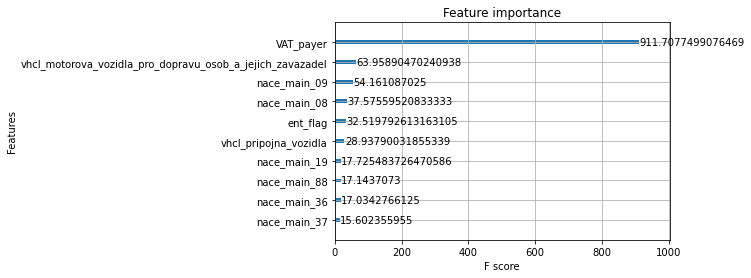

In [7]:
xgb.plot_importance(moto_model, max_num_features=10, importance_type='gain')

## Shap explainer

In [29]:
explainer = shap.TreeExplainer(moto_model)
shap_values = explainer.shap_values(x)

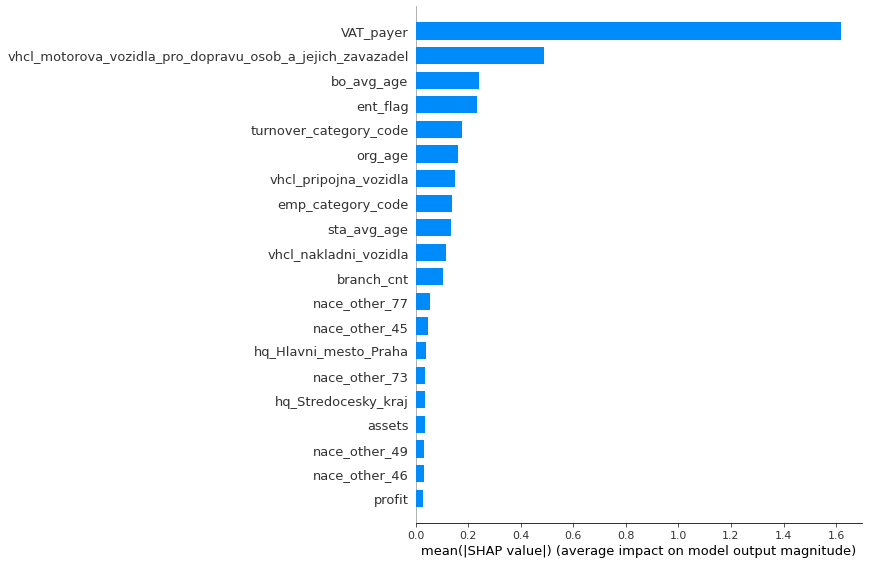

In [30]:
shap.summary_plot(shap_values, x, plot_type="bar")

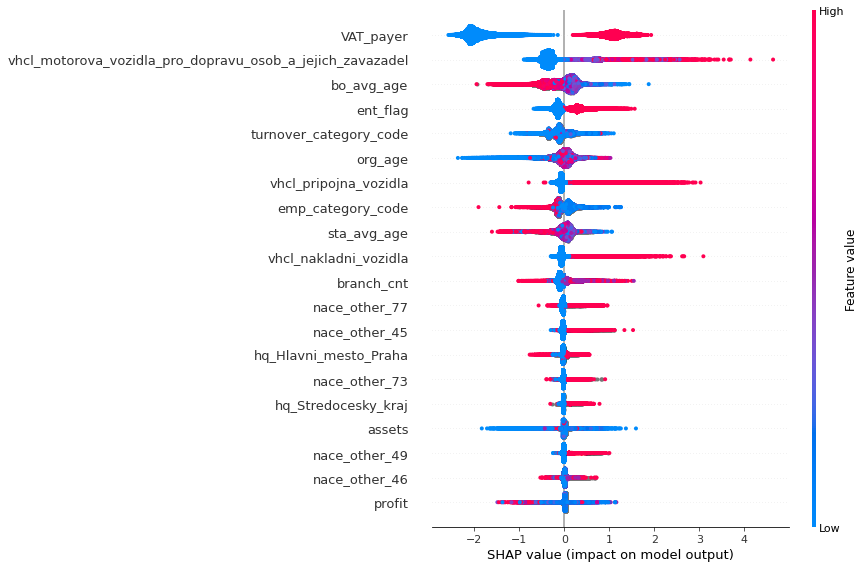

In [31]:
shap.summary_plot(shap_values, x)

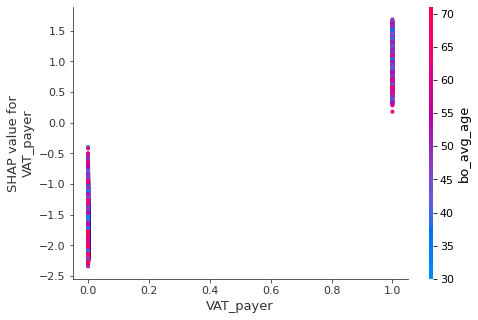

In [47]:
# shap.dependence_plot("VAT_payer", shap_values, x, interaction_index="org_age")
# shap.dependence_plot("bo_avg_age", shap_values, x,interaction_index='emp_category_code')
shap.dependence_plot("VAT_payer", shap_values, x, interaction_index='bo_avg_age')
